In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

%matplotlib inline

In [2]:
users = pd.read_csv("./takehome_users.csv",encoding='latin-1')
engagement = pd.read_csv("./takehome_user_engagement.csv",encoding='latin-1')

users.creation_time = pd.to_datetime(users.creation_time)
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [3]:
# users with at least 3 logins. need to further filter to those which logged in 3 times within a week
# instantiating the extra variable may not be necessary, but makes the code a bit more readable

potential_adopted = list(engagement.groupby('user_id').count()[engagement.groupby('user_id').count().time_stamp > 2].index)
engagement_of_potentials = engagement[engagement.user_id.isin(potential_adopted)].copy()

In [4]:
# note, this approach would not work if the dataset were much larger..this is computationally expensive

adopted_users = []

for user in potential_adopted:
    user_logins = engagement_of_potentials[engagement_of_potentials.user_id==user].copy()
    for index in user_logins.index:
        window_min = user_logins.loc[index,'time_stamp']
        window_max = user_logins.loc[index,'time_stamp'] + np.timedelta64(7,'D')
        
        if len(user_logins[(user_logins.time_stamp >= window_min) & (user_logins.time_stamp <= window_max)]) >= 3:
            adopted_users.append(user)
            break
        

In [5]:
users['adopted'] = users.object_id.isin(adopted_users).astype(int)

In [6]:
# this is not really necessary to separate adopted/unadopted into two dataframes

adopted_user_info = users[users.object_id.isin(adopted_users)].copy()
unadopted_user_info = users[~users.object_id.isin(adopted_users)].copy()

In [7]:
# there are much more unadopted users than adopted

print(len(adopted_user_info))
print(len(unadopted_user_info))

1656
10344


In [8]:
# a greater proportion of adopted users create their account through a guest invite or through their google account
# conversely, a relatively greater proportion of users end up not adopting the product when signing up through
# personal projects

print((adopted_user_info.groupby('creation_source').count()/len(adopted_user_info))['object_id'])
print('')
print((unadopted_user_info.groupby('creation_source').count()/len(unadopted_user_info))['object_id'])

creation_source
GUEST_INVITE          0.222826
ORG_INVITE            0.346618
PERSONAL_PROJECTS     0.103865
SIGNUP                0.182367
SIGNUP_GOOGLE_AUTH    0.144324
Name: object_id, dtype: float64

creation_source
GUEST_INVITE          0.173434
ORG_INVITE            0.355762
PERSONAL_PROJECTS     0.187452
SIGNUP                0.172564
SIGNUP_GOOGLE_AUTH    0.110789
Name: object_id, dtype: float64


In [9]:
# frequency of opting into mailing list is about the same for adopted and unadopted users. not predictive

print(adopted_user_info.opted_in_to_mailing_list.mean())
print(unadopted_user_info.opted_in_to_mailing_list.mean())

0.25905797101449274
0.24796983758700697


In [10]:
# about equal frequency of enabling marketing email drop as well. not predictive

print(adopted_user_info.enabled_for_marketing_drip.mean())
print(unadopted_user_info.enabled_for_marketing_drip.mean())

0.15519323671497584
0.1483952049497293


In [11]:
# it is difficult to get users who create an account with an organization to adopt the product..
# on average, much more users who create an account with an organization tend not to adopt the product than do (about 6 fold)

# about 4 users adopt per organizational invite; about 24 users do not adopt per organizational invite

print(adopted_user_info.groupby('org_id')['object_id'].count().mean())
print(unadopted_user_info.groupby('org_id')['object_id'].count().mean())

4.129675810473816
24.805755395683452


In [12]:
# almost twice as often, users who are invited by another user end up not adopting the product. this is not necessarily
# because invitations dissuade users from adopting the product..it's more likely an instrinsic cause of users tending
# not to adopt the product

print(adopted_user_info.groupby('invited_by_user_id')['object_id'].count().mean())
print(unadopted_user_info.groupby('invited_by_user_id')['object_id'].count().mean())

1.2278645833333333
2.2884615384615383


In [13]:
# on average, in total, adopted users log in far more often than unadopted users (close to 100 fold)..regardless of whether
# the logins were contained in a 7 day period

print(engagement[engagement.user_id.isin(adopted_users)].groupby('user_id').count().mean())
print('')
print(engagement[~engagement.user_id.isin(adopted_users)].groupby('user_id').count().mean())

time_stamp    119.762681
visited       119.762681
dtype: float64

time_stamp    1.338077
visited       1.338077
dtype: float64


Text(0.5,0,'User ID')

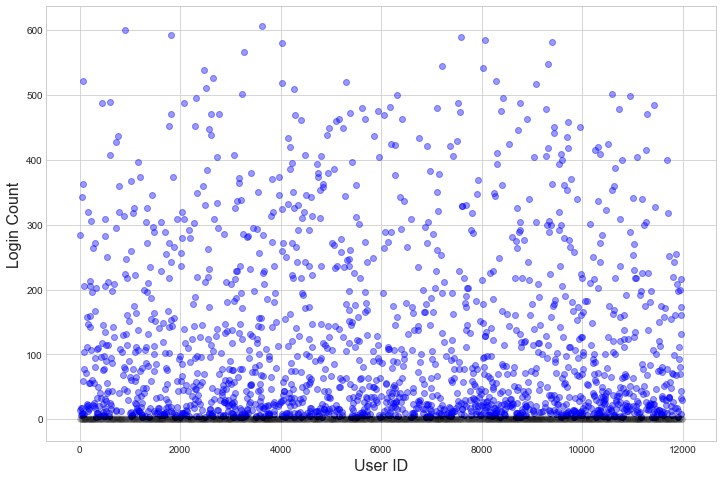

In [14]:
# varying across the x-axis is somewhat nonsensical..those are IDs, not numerical values.
# however, we can see that unadopted users (in black) have login counts all close to 0 relative to the spread of login
# counts we see on the adopted users (in blue)

# we greatly reduce the opacity of the unadopted users because of their greater count and density near the y = 0 line

# any user with a login count in the area dominated by blue data points will most likely be an adopted user
# (this is intuitive..with more logins, there is more likelihood of a triplet of logins within a week)

sns.set_style('whitegrid')

fig, ax = plt.subplots(1,1,figsize=(12,8))

ax.scatter(engagement[engagement.user_id.isin(adopted_users)].groupby('user_id').count().index,\
            engagement[engagement.user_id.isin(adopted_users)].groupby('user_id').count().visited,alpha=0.4,facecolor='b')
ax.scatter(engagement[~engagement.user_id.isin(adopted_users)].groupby('user_id').count().index,\
            engagement[~engagement.user_id.isin(adopted_users)].groupby('user_id').count().visited,alpha=0.01,facecolor='k')
ax.set_ylabel('Login Count',fontsize=16)
ax.set_xlabel('User ID',fontsize=16)

In [15]:
# consolidating aggregated information from engagements df to users df

users = users.set_index('object_id')

users['login_counts'] = 0
users['last_login'] = np.NaN

users.loc[engagement.user_id.unique(),'login_counts'] = engagement.groupby('user_id').count()['visited']
users.loc[engagement.user_id.unique(),'last_login'] = engagement.groupby('user_id').max()['time_stamp']

In [16]:
# converting unix timestamp to datetime. seems this column has the same information as 'last_login' 
# although, some datapoints are off by a day

import datetime

users.loc[users.last_session_creation_time.notnull().index,'last_session_creation_time'] = \
    users[users.last_session_creation_time.notnull()].last_session_creation_time\
    .apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))

users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time)

In [17]:
# using last_session_creation_time results in some negative time values.. we'll use 'last_login'
# days_since_creation is the number of days passed between creation and last login

users['days_since_creation'] = (users.last_login - users.creation_time).apply(lambda x: x.days)

In [18]:
model_input = users.drop(['name','email','creation_time','last_session_creation_time','org_id',
                         'invited_by_user_id','last_login'],axis=1)

In [19]:
model_input = model_input.merge(pd.get_dummies(model_input.creation_source),left_index=True,right_index=True)\
                .drop('creation_source',axis=1)

In [24]:
# the only NaN values are in days_since_creation, for data points with no 'last_login'
# filling the values with 0 makes sense, since this implies the user did not login again after creation

model_input = model_input.fillna(0)

In [27]:
from sklearn.cluster import KMeans

clus = KMeans(n_clusters=10)
clus.fit(model_input)
model_input['cluster'] = clus.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [36]:
# unadopted users exist in only 3 clusters, whereas adopted users exist in all clusters

print(model_input[model_input.adopted==0].cluster.unique())
print(model_input[model_input.adopted==1].cluster.unique())

[0 9 4]
[4 7 9 6 3 2 5 8 1 0]


In [38]:
model_input[model_input.cluster.isin([0,9,4])].describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,login_counts,days_since_creation,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,cluster
count,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000,10989.000000
mean,0.247520,0.148876,0.058695,1.887433,8.942761,0.176267,0.355719,0.183001,0.172900,0.112112,0.581764
std,0.431591,0.355983,0.235064,4.985324,27.015516,0.381065,0.478752,0.386685,0.378178,0.315519,2.070336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,76.000000,189.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [39]:
# on average, adopted users' most recent login is much later since their creation time. all other 
# metrics are very similar..

model_input.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,login_counts,days_since_creation,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,cluster
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,0.138000,17.326417,43.543083,0.180250,0.354500,0.175917,0.173917,0.115417,0.904417
std,0.432742,0.356432,0.344914,64.287839,126.352426,0.384412,0.478381,0.380765,0.379054,0.319537,2.353241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,606.000000,729.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000
